### Preliminary

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Algorithms
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDRegressor, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier,  GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor, XGBClassifier

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #regression

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data
let's load our **clean** and **feature-engineered** data

In [2]:
data = pd.read_csv( 'data/centadata_clean.csv', index_col= 0)
data.txdate = data.txdate.astype('datetime64')
data.region = data.region.astype('category')
data.flat_type = data.flat_type.astype('category')

For our model, we are only going to use `region`, `saleablearea`, `building_age`, and `floor_number` to predict `adj_price_per_sqf`

`region` we'll one-hot encode:

In [4]:
region_dummies = pd.get_dummies( data.region, prefix = 'reg_')
region_dummies.index = data.index

where `adj_price_per_sqf` is defined as...

In [4]:
cci_data = pd.read_csv('data/cci_small_medium_2017_2018.csv', header = None, names = ['Date', 'CCI'])
cci_data['idx_date'] = cci_data['Date'].apply( lambda x: x.split(" - ")[0])
cci_data.idx_date = cci_data.idx_date.astype('datetime64')

def GetCCI(inDate):
    dfilter = (cci_data.idx_date <= inDate) 
    return cci_data[dfilter]['CCI'].iloc[0]

data['adj_price_per_sqf'] = data.apply( 
    lambda x: x.price_per_sqf * GetCCI(datetime.today())/ GetCCI(x.txdate) , 
    axis = 1
)

And now we got our model data...

#### Export or Import the model Data to save time

In [2]:
fname = 'data/model_data.csv'
uinput = input( 'Read or Write model data? [R]/[W]').upper()

if uinput == 'R':
    data = pd.read_csv( fname , index_col= 0)
    print(f'Data from {fname} loaded into object: data')
elif uinput == 'W':
    data.to_csv( fname )
    print( f'Data written to {fname}')
else:
    print( f'Unsupported input: {uinput}; nothing done.')

Read or Write model data? [R]/[W]R
Data from data/model_data.csv loaded into object: data


In [5]:
l_model_col = ['saleablearea', 'building_age', 'floor_number','adj_price_per_sqf']
df_model = data[ l_model_col + ['flat_type']].join( region_dummies )

Furthermore, we are only looking at:
* _normal_ `flat_type`
* _small/medium units_ as defined by Centaline [here](http://www1.centadata.com/cci/CCUI_e.html)

In [6]:
model_filter = (df_model.flat_type == 'n') & (df_model.saleablearea <= 1076)
df_model = df_model[model_filter].drop(columns = 'flat_type')

Our target looks pretty normal now

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


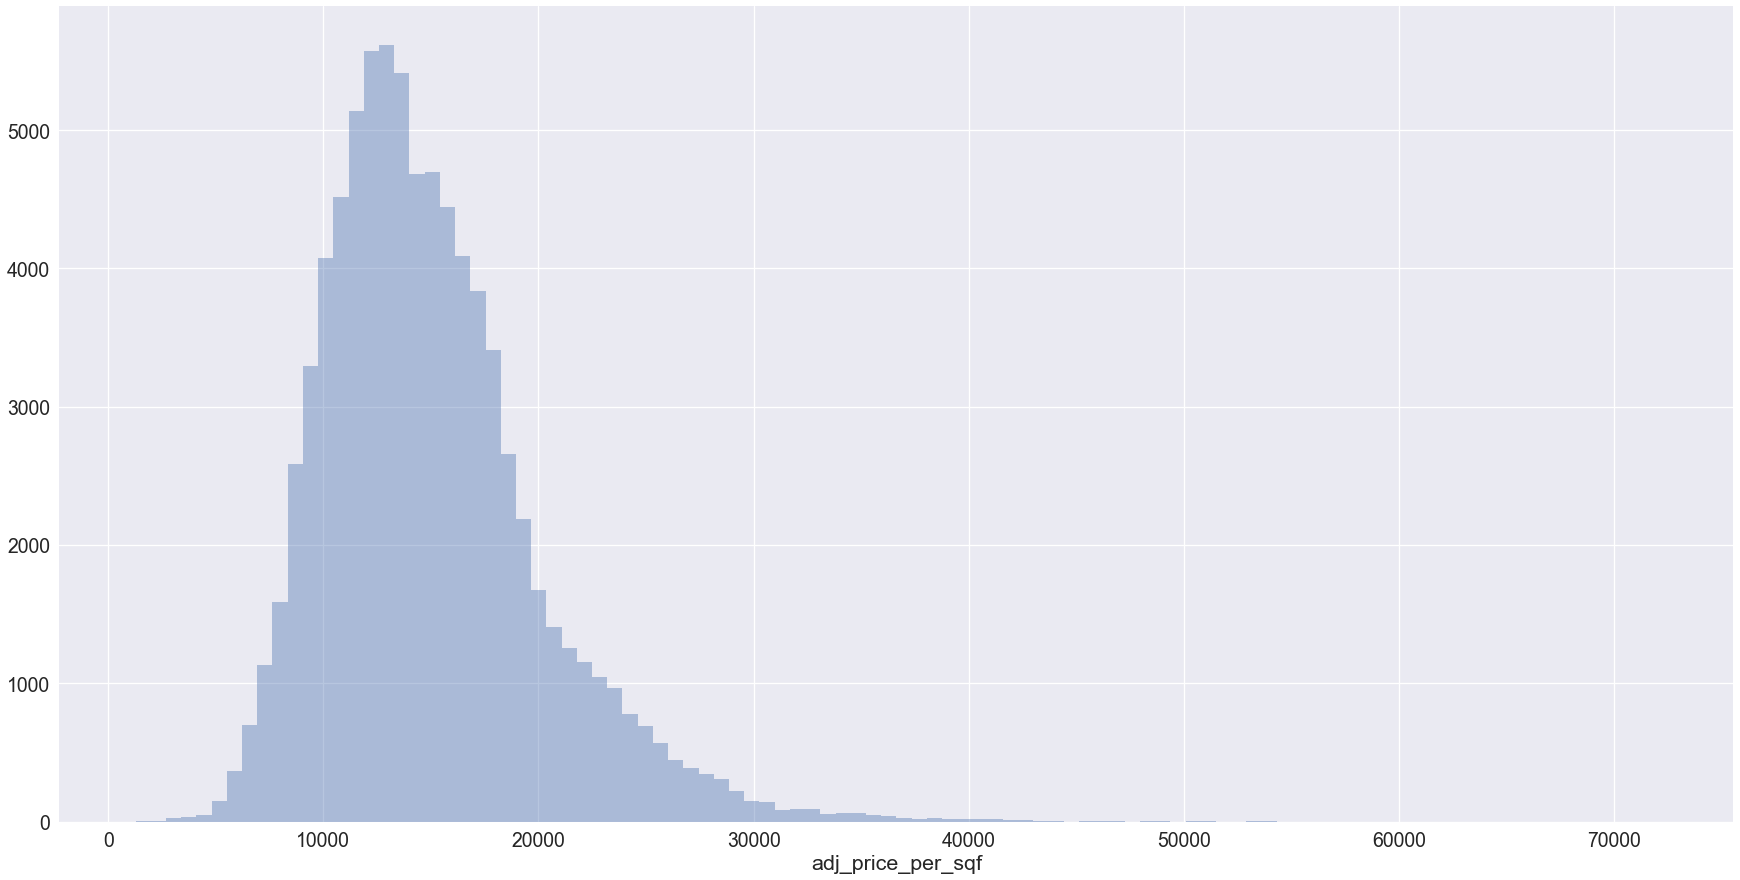

In [7]:
plt.figure(figsize = (30,15))
sns.set(style = 'darkgrid', context = 'talk', font_scale= 1.5)
sns.distplot( df_model.adj_price_per_sqf, bins = 100, kde = False)

## Training the Model

### Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split( 
    df_model.drop(columns= ['adj_price_per_sqf']),
    df_model.adj_price_per_sqf,
    test_size = 0.3,
    random_state = 420
)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (57801, 59)
X_test shape: (24772, 59)


### Train Model
which model is best?

In [44]:
def batch_regress( X_train, y_train, X_test, y_test, verbose = True):
    
    dict_regressor = {
        'Linear Regressor': LinearRegression(),
        'Lasso': Lasso(alpha= 1.0),
        'Decision Tree': DecisionTreeRegressor(),
        'RandomForestRegressor': RandomForestRegressor(n_estimators= 100, random_state = 420),
        'Gradient Boost Regressor': GradientBoostingRegressor()
    }
    
    dict_models = {}
    for regressor in dict_regressor:
        t_start = time.clock()
        model = dict_regressor[ regressor ]
        model.fit( X_train, y_train)
        t_end = time.clock()

        train_score = model.score( X_train, y_train)
        test_score = model.score( X_test, y_test)

        dict_models[ regressor ] = {'model': regressor,
                                   'train_score': train_score,
                                   'test_score': test_score,
                                   'compute_time': t_end - t_start}
        if verbose:
            print(f'Trained {regressor} in {"{:.2f}".format(t_end - t_start)} s.')
        
    return dict_models

In [45]:
batch_regress( X_train, y_train, X_test, y_test)

Trained Linear Regressor in 0.25 s.
Trained Lasso in 2.84 s.
Trained Decision Tree in 0.67 s.
Trained RandomForestRegressor in 40.96 s.
Trained Gradient Boost Regressor in 5.60 s.


{'Decision Tree': {'compute_time': 0.673452999999995,
  'model': 'Decision Tree',
  'test_score': 0.8114838941552002,
  'train_score': 0.9950539403619533},
 'Gradient Boost Regressor': {'compute_time': 5.602676000000002,
  'model': 'Gradient Boost Regressor',
  'test_score': 0.7045484152124855,
  'train_score': 0.7088818653135084},
 'Lasso': {'compute_time': 2.8382810000000234,
  'model': 'Lasso',
  'test_score': 0.6718699227191075,
  'train_score': 0.6753744834558533},
 'Linear Regressor': {'compute_time': 0.24697900000001027,
  'model': 'Linear Regressor',
  'test_score': 0.6720836739761513,
  'train_score': 0.6757635380628403},
 'RandomForestRegressor': {'compute_time': 40.95695600000002,
  'model': 'RandomForestRegressor',
  'test_score': 0.8850498499216379,
  'train_score': 0.9809018976677648}}

**Decision Tree** and **RandomForestRegressor** gave the best results

## Deploy and Evaluate the model

In [9]:
ser_deploy = X_test.iloc[0]
deploy_dict = ser_deploy.to_dict()
for i in deploy_dict:
    deploy_dict[i] = 0

In [10]:
_age = input('Please enter building age:')
_floor_number = input('Please enter floor number:')
_saleablearea = input('Please enter Saleable Area:')

# region we need to encode
l_region = list(sorted(data.region.unique()))
region_dict = { i : region for i, region in enumerate(l_region)}
print(f"Here's out region number map:")
for region in region_dict:
    print(f'{region}: {region_dict[region]}')
region_num = input(f'Please enter region number:')
# _region = 'reg__' + region_dict[int(region_num)]
#            reg__Wanchai/Causeway Bay
deploy_dict['building_age'] = int(_age)
deploy_dict['floor_number'] = int(_floor_number)
deploy_dict['saleablearea'] = int(_saleablearea)
#deploy_dict[_region] = 1

for key in deploy_dict:
    if region_dict[ int(region_num) ] in key:
        deploy_dict[ key ] = 1

Please enter building age:10
Please enter floor number:5
Please enter Saleable Area:800
Here's out region number map:
0: Aberdeen/Ap Lei Chau
1: Belvedere Garden/Castle Peak Road (Tsuen Wan Porti
2: Cheung Sha Wan West
3: Cheung Sha Wan/Sham Shui Po
4: Cyber-Port
5: Diamond Hill/Wong Tai Sin
6: Discovery Bay
7: Fairview Park/Palm Spring/The Vineyard
8: Fotan/Shatin Mid Level/Kau To Shan
9: Happy Valley/Mid Level East
10: Heng Fa Chuen
11: Ho Man Tin/King's Park
12: Hung Hom
13: Kai Tak
14: Kennedy Town/Sai Yin Pun
15: Kowloon Bay/Ngau Chi Wan
16: Kowloon Station
17: Kowloon Tong/Beacon Hill
18: Kwai Chung
19: Kwun Tong
20: Lam Tin/Yau Tong
21: Ma On Shan
22: Ma Wan/Park Island
23: Mei Foo/Wonderland
24: Mid Level Central
25: Mid Level North Point
26: Mid Level West
27: Mongkok/Yaumatei
28: North Point/Fortress Hill
29: Olympic Station
30: Peak/South
31: Quarry Bay/Kornhill
32: Sai Kung
33: Sham Tseng/Castle Peak Road (Tuen Mun Portion)
34: Shatin
35: Shau Kei Wan/Chai Wan
36: Sheung Sh

In [11]:
s = pd.Series( deploy_dict, index = deploy_dict.keys())
deploy_df = pd.DataFrame(s).T

#deploy_model = dict_model['RandomForestRegressor']['model']
deploy_model = RandomForestRegressor(n_estimators= 100, random_state = 420,)
deploy_model.fit( X_test, y_test)
deploy_model.predict( deploy_df )

array([10199.46072689])

In [19]:
pred = deploy_model.predict( deploy_df )
float(pred) * deploy_df.saleablearea.iloc[0]

8159568.581514353

### Evaluate the model
* feature importance
* does it work better or worst without _domain knowledge_ (i.e. without filtering out big flats)
* Grid Search CV
* Looking deeper into the decision tree model
* Getting a confidence interval for our price

Text(0,0.5,'Predictions')

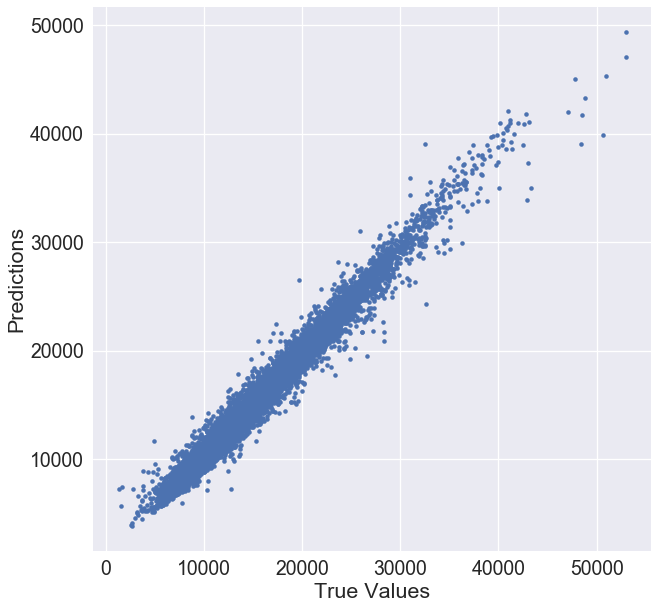

In [12]:
prediction = deploy_model.predict(X_test)

plt.figure(figsize = (10,10))
plt.plot( y_test, prediction, '.')
plt.xlabel('True Values')
plt.ylabel('Predictions')

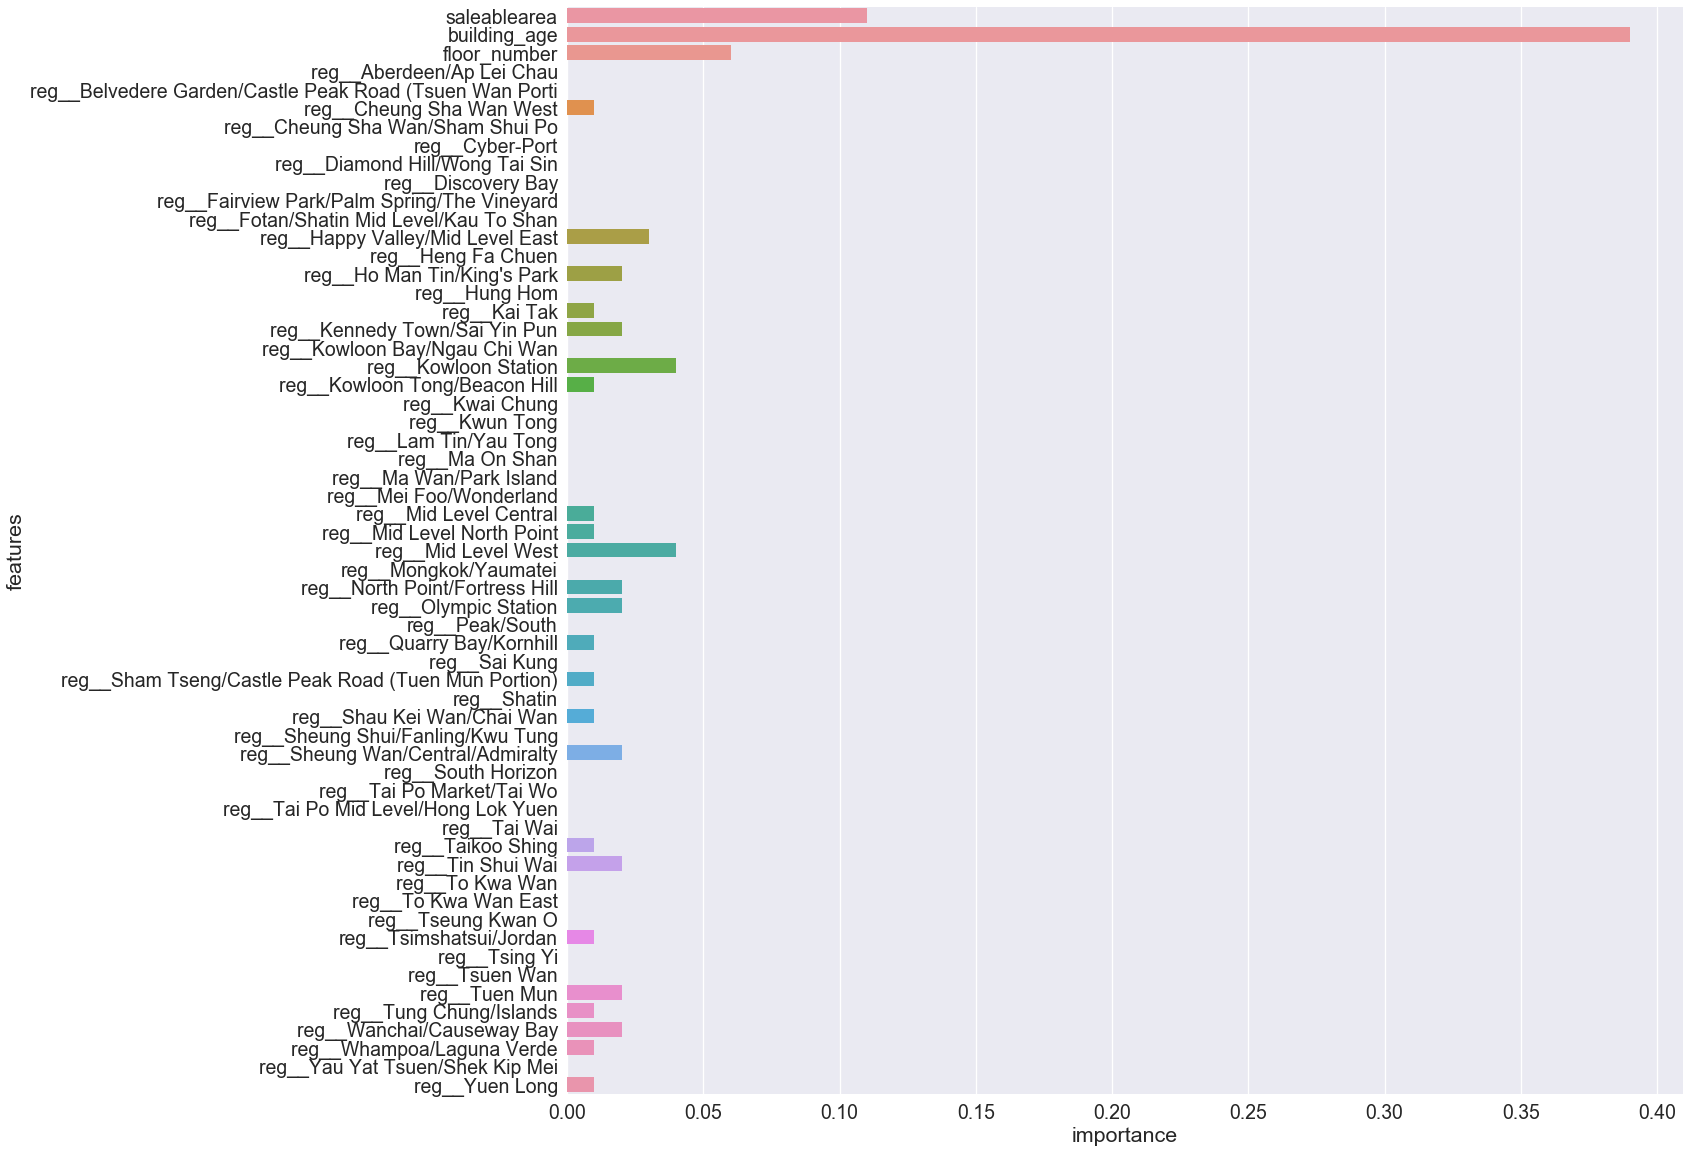

In [13]:
feat_importance = { feat: round(importance, 2) 
                   for feat, importance in 
                   zip(X_test.columns, deploy_model.feature_importances_ )
                  }
df_featimp = pd.DataFrame(pd.Series( feat_importance , index = feat_importance.keys() )).reset_index()
df_featimp.columns = ['features', 'importance']
#df_featimp.sort_values( by = 'importance', ascending = False)

plt.figure(figsize = (20,20))
sns.set(style = 'darkgrid', context = 'talk', font_scale= 1.5)
sns.barplot( x = 'importance', y = 'features', data = df_featimp)

### Visualizing a Tree in the Forest

In [47]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz # requires graphviz which can be brew installed
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_test, y_test)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'data/small_tree.dot', feature_names = list(X_test.columns), rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('data/small_tree.dot')

graph.write_png('data/small_tree.png');

## References:
* [Koehrsen: Random Forest in Python](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)  
* [Koehrsen: Random Forest explained](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)

* [Classification with SK-Learn](http://ataspinar.com/2017/05/26/classification-with-scikit-learn/) for some very helpful modeling training code  
* [Predicition Intervals for Random Forests](https://blog.datadive.net/prediction-intervals-for-random-forests/)